In [6]:
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import pickle as pkl
import random
from scipy.signal import savgol_filter

In [17]:
class myseq:
    empty_char = 'U'
    def __init__(self,seq):
        self.seq = list(seq)
        self.original_seq = copy.deepcopy(self.seq)
        self.n = len(self.seq)
    def maskerInit(self,seed):
        self.toMask = np.random.RandomState(seed=seed).permutation(self.n)
        self.toMaskId = 0
    def maskerReset(self):
        self.toMaskId = 0
        self.seq = copy.deepcopy(self.original_seq)
    def maskNext(self):
        if self.toMaskId >= self.n:
            print "masker already finished. did nothing here."
            return
        self.seq[self.toMask[self.toMaskId]] = myseq.empty_char
        self.toMaskId += 1
    def count(self):
        # bb,ii,oo [t]: #possibilities ending at place t-1 with B/I/O. t=0,1,...,len(seq)
        bb = 0
        ii = 0
        oo = 1
        for step in range(0,self.n):
            bb_prv = bb
            ii_prv = ii
            oo_prv = oo
            bb = bb_prv+oo_prv+ii_prv
            ii = bb_prv+ii_prv
            oo = bb
            if self.seq[step] != myseq.empty_char:
                if self.seq[step] != 'B':
                    bb = 0
                if self.seq[step] != 'I':
                    ii = 0
                if self.seq[step] != 'O':
                    oo = 0
        return bb+ii+oo
    def early_stop(self,seed):
        self.maskerInit(seed)
        allCnt = [self.count()]
        for step in range(self.n):
            self.maskNext()
            allCnt.append(self.count())
        return allCnt

class genSeq:
    def __init__(self,length,seed):
        self.len = length
        self.seed = seed
        random.seed(seed)
    def nextSeq(self):
        seq = ['O']
        for i in range(self.len):
            r = random.random()
            if seq[-1] == 'O':
                if r < 0.5:
                    seq.append('B')
                else:
                    seq.append('O')
            else:
                if r < 1.0/3:
                    seq.append('B')
                elif r < 2.0/3:
                    seq.append('I')
                else:
                    seq.append('O')
        return seq[1:]
    def reset(self):
        random.seed(seed)

In [20]:
NumExp = 1000
NumSeq = 100
seqlength = 10
seqgen = genSeq(seqlength,0)

allIk = []
for seqid in range(NumSeq):
    seq = seqgen.nextSeq()
    allCnt = []
    for seed in range(0,NumExp):
        a = myseq(seq)
        allCnt += a.early_stop(seed)
    allCnt = np.array(allCnt).reshape((NumExp,a.n+1))
    Ik = np.mean(np.log2(allCnt),axis=0)
    Ik = Ik[::-1]
    allIk = np.concatenate((allIk,Ik))
allIk = np.array(allIk).reshape((NumSeq,seqlength+1))

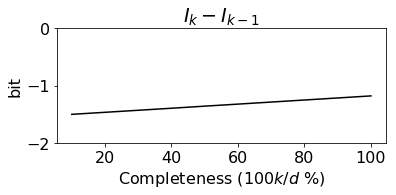

In [21]:
plt.figure(figsize=(6,3))
# plt.subplot(211)
# plt.plot([100.0*x/seqlength for x in range(seqlength)],savgol_filter(np.mean(allIk,axis=0),3,2),'k')
# plt.title("$I_k$ (d=%d)" % (seqlength))
# plt.ylabel("bit")
# plt.rcParams.update({'font.size':16})
# #plt.ylim(ymin=1/10000)
# # plt.xlim((10,70))
# plt.tight_layout()

# plt.subplot(212)

b = np.empty([allIk.shape[0],allIk.shape[1]-1])
for i in range(0,allIk.shape[0]):
    for j in range(1,allIk.shape[1]):
        b[i,j-1] = allIk[i,j]-allIk[i,j-1]


plt.plot([100.0*x/seqlength for x in range(1,seqlength+1)],savgol_filter(np.mean(b,axis=0),7,1),'k')
plt.xlabel("Completeness ($100k/d$ %)")
plt.ylabel("bit")
plt.title("$I_{k}-I_{k-1}$")
plt.rcParams.update({'font.size':16})
plt.ylim(ymin=-2,ymax=0)
# plt.xlim((10,70))
plt.tight_layout()

plt.savefig("Chunker_d%d_seq%d_rep%d.pdf" %(seqlength,NumSeq,NumExp))
plt.show()

In [22]:
pkl.dump(allIk,open("Chunker_d%d_seq%d_rep%d.pkl" %(seqlength,NumSeq,NumExp),"wb"))

In [41]:
Ik = np.mean(np.log2(allCnt),axis=0)
Ik[::-1]

array([ 16.19508379,  14.5854852 ,  13.1049473 ,  11.66291068,
        10.1601606 ,   8.71894241,   7.22475694,   5.77840457,
         4.52669842,   3.31718887,   2.12969028,   1.014376  ])

In [12]:
allIk.shape

(100, 10)